In [ ]:
#!unzip '/home/jupyter/datasphere/project/CRACK500.zip'

Unknown instance spec: Please select VM configuration

In [6]:
pip install segmentation_models_pytorch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 7.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import math
import cv2
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import segmentation_models_pytorch as smp

import torchmetrics as tm

In [2]:

def mirror_pad(image, target_size=(640, 640)):
    height, width = image.shape[:2]
    target_width, target_height = target_size

    if width >= target_width or height >= target_height:
        return cv2.resize(image, target_size, interpolation=cv2.INTER_NEAREST if len(image.shape) == 2 else cv2.INTER_LINEAR)

    left_pad = max((target_width - width) // 2, 0)
    right_pad = max(target_width - width - left_pad, 0)
    top_pad = max((target_height - height) // 2, 0)
    bottom_pad = max(target_height - height - top_pad, 0)

    padded_image = cv2.copyMakeBorder(
        image, top_pad, bottom_pad, left_pad, right_pad,
        borderType=cv2.BORDER_REFLECT
    )

    return padded_image

class SegData(Dataset):
    def __init__(self, dataset_path, file_name, transform=None):
        self.images = []
        self.masks = []
        self.transform = transform
        self.dataset_path = dataset_path
        file_path = Path(dataset_path) / file_name
        # Читаем файлы из train.txt
        with open(file_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            image_path, mask_path = line.strip().split()
            self.images.append(image_path)
            self.masks.append(mask_path)

    def __getitem__(self, idx):
        image_name = Path(self.dataset_path) / self.images[idx]
        mask_name = Path(self.dataset_path) / self.masks[idx]
        image = cv2.imread(str(image_name))
        #print(image_name)
        #plt.imshow(torch.from_numpy(image))
        #plt.show()
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_name), cv2.IMREAD_UNCHANGED)
        image = mirror_pad(image)
        #plt.imshow(torch.from_numpy(image))
        #plt.show()
        mask = mirror_pad(mask)

        #plt.imshow(torch.from_numpy(mask))
        #plt.show()
        image = image.astype('uint8')
        mask = mask.astype('uint8')
        mask = np.expand_dims(mask, axis=2)

        if(self.transform is not None):
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)
            image = image.permute(2, 0, 1)
            image = image.float()/255
            mask = mask.permute(2, 0, 1)
            mask = mask.float()/255
            mask = mask.squeeze().long()
        else:
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)
            image = image.permute(2, 0, 1)
            image = image.float()/255
            mask = mask.permute(2, 0, 1)
            mask = mask.float()/255
            mask = mask.squeeze().long()
        return image, mask
    def __len__(self):
        return len(self.images)
    
    
class DeepLabv3_trainer():
    def __init__(self,model,dataset_dir_path):
        self.model = model
        self.dataset_dir_path = dataset_dir_path
        
        train_ds = SegData(dataset_path=dataset_dir_path, file_name='train.txt', transform=None)
        val_ds = SegData(dataset_path=dataset_dir_path, file_name='val.txt', transform=None)
        test_ds = SegData(dataset_path=dataset_dir_path, file_name='test.txt', transform=None)

        self.train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0, drop_last=True)
        self.val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=True, num_workers=0, drop_last=True)
        self.test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=True, num_workers=0, drop_last=True)



    def train_model(self, save_folder, epohs = 30, device = 'cuda'):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(self.model.parameters())
        self.epochs = epohs
        self.device = device
        if self.device == 'cuda':
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)

        self.model = self.model.to(device)

        acc = tm.Accuracy(task="multiclass", average="micro", num_classes=2).to(device)
        f1 = tm.F1Score(task="multiclass", average="macro", num_classes=2).to(device)
        iou_metric = tm.JaccardIndex(task="binary").to(device)
        prec = tm.Precision(task="binary").to(device)
        rec = tm.Recall(task="binary").to(device)

        epohs_arr = []
        t_loss = []
        t_acc = []
        t_f1 = []
        t_prec = []
        t_rec = []
        v_loss = []
        v_acc = []
        v_f1 = []
        t_iou = []
        v_iou = []
        v_prec = []
        v_rec = []


        self.model.train()
        start_epoch = 0 #10

        start_f1VMax = 0 #0.8878
        f1VMax = 0.0 + start_f1VMax

        print('starts to learn')
        for epoch in range(start_epoch, start_epoch + self.epochs+1):
            running_loss = 0.0

            for inputs, targets in self.train_dl:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                optimizer.zero_grad()
                
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)

                acc.update(outputs, targets)
                f1.update(outputs, targets)
                iou_metric.update(torch.argmax(outputs, dim=1), targets)
                prec.update(torch.argmax(outputs, dim=1), targets)
                rec.update(torch.argmax(outputs, dim=1), targets)

                loss.backward()

                optimizer.step()

                running_loss += loss.item()


            epoch_loss = running_loss / len(self.train_dl)
            accT = acc.compute()
            f1T = f1.compute()
            m_iouT = iou_metric.compute()
            precT = prec.compute()
            recT = rec.compute()
            

            print(f'Epoch: {epoch}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {accT:.4f}, Training F1: {f1T:.4f}, Training IoU: {m_iouT:.4f}')
            print(f'Training Precision: {precT:.4f}, Training Recall: {recT:.4f}')

            epohs_arr.append(epoch)
            t_loss.append(epoch_loss)
            t_acc.append(accT.detach().cpu().numpy())
            t_f1.append(f1T.detach().cpu().numpy())
            t_iou.append(m_iouT.detach().cpu().numpy())
            t_prec.append(precT.detach().cpu().numpy())
            t_rec.append(recT.detach().cpu().numpy())

            acc.reset()
            f1.reset()
            iou_metric.reset()
            prec.reset()
            rec.reset()

            with torch.no_grad():
                running_loss_v = 0.0

                for inputs, targets in self.val_dl:
                    inputs, targets = inputs.to(device), targets.to(device)

                    outputs = self.model(inputs)
                    loss_v = criterion(outputs, targets)

                    running_loss_v += loss_v.item()

                    acc.update(outputs, targets)
                    f1.update(outputs, targets)
                    iou_metric.update(torch.argmax(outputs, dim=1), targets)
                    prec.update(torch.argmax(outputs, dim=1), targets)
                    rec.update(torch.argmax(outputs, dim=1), targets)

            epoch_loss_v = running_loss_v/len(self.val_dl)
            accV = acc.compute()
            f1V = f1.compute()
            m_iouV = iou_metric.compute()
            precV = prec.compute()
            recV = rec.compute()

            print(f'Validation Loss: {epoch_loss_v:.4f}, Validation Accuracy: {accV:.4f}, Validation F1: {f1V:.4f}, Validation IoU: {m_iouV:.4f}')
            print(f'Validation Precision: {precV:.4f}, Validation Recall: {recV:.4f}')

            v_loss.append(epoch_loss_v)
            v_acc.append(accV.detach().cpu().numpy())
            v_f1.append(f1V.detach().cpu().numpy())
            v_iou.append(m_iouV.detach().cpu().numpy())
            v_prec.append(precV.detach().cpu().numpy())
            v_rec.append(recV.detach().cpu().numpy())


            acc.reset()
            f1.reset()
            iou_metric.reset()
            prec.reset()
            rec.reset()

            f1V2 = f1V.detach().cpu().numpy()
            if f1V2 > f1VMax:
                f1VMax = f1V2
                torch.save(self.model.state_dict(), Path(save_folder) / 'crack_dlv3_model.pt')
                print(f'Model saved for epoch {epoch}.')

        Sepohs = pd.Series(epohs_arr, name="epoch")
        St_loss = pd.Series(t_loss, name="training_loss")
        St_acc = pd.Series(t_acc, name="training_accuracy")
        St_f1 = pd.Series(t_f1, name="training_f1")
        St_iou = pd.Series(t_iou, name="training_iou")
        St_prec = pd.Series(t_prec, name="training_prec")
        St_rec = pd.Series(t_rec, name="training_rec")
        Sv_loss = pd.Series(v_loss, name="val_loss")
        Sv_acc = pd.Series(v_acc, name="val_accuracy")
        Sv_f1 = pd.Series(v_f1, name="val_f1")
        Sv_iou = pd.Series(v_iou, name="val_iou")
        Sv_prec = pd.Series(v_prec, name="val_prec")
        Sv_rec = pd.Series(v_rec, name="val_rec")


        resultsDF = pd.concat([Sepohs, St_loss, St_acc, St_f1, St_iou, St_prec, St_rec, Sv_loss, Sv_acc, Sv_f1, Sv_iou, Sv_prec, Sv_rec], axis=1)

        resultsDF.to_csv(Path(save_folder) / "results_crack.csv")

In [3]:
encoder_weights = 'imagenet'
activation = None

model = smp.DeepLabV3(
    encoder_weights=encoder_weights,
    classes=2,
    activation=activation,
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 140MB/s] 


In [ ]:
#если начинаем не с начала

#checkpoint_path = "/home/jupyter/datasphere/project/results/crack_dlv3_model.pt"
#model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))



Unknown instance spec: Please select VM configuration

In [ ]:

dataset_path_dir = '/home/jupyter/datasphere/project/CRACK500'
save_folder = '/home/jupyter/datasphere/project/results'

trainer = DeepLabv3_trainer(model, dataset_path_dir)
trainer.train_model(save_folder)

cuda
starts to learn
Epoch: 0, Training Loss: 0.1604, Training Accuracy: 0.9386, Training F1: 0.7565, Training IoU: 0.3755
Training Precision: 0.5162, Training Recall: 0.5794
Validation Loss: 0.0736, Validation Accuracy: 0.9725, Validation F1: 0.8688, Validation IoU: 0.6027
Validation Precision: 0.7703, Validation Recall: 0.7347
Model saved for epoch 0.
Epoch: 1, Training Loss: 0.0874, Training Accuracy: 0.9670, Training F1: 0.8550, Training IoU: 0.5718
Training Precision: 0.7651, Training Recall: 0.6936
Validation Loss: 0.0694, Validation Accuracy: 0.9731, Validation F1: 0.8820, Validation IoU: 0.6371
Validation Precision: 0.7385, Validation Recall: 0.8228
Model saved for epoch 1.
Epoch: 2, Training Loss: 0.0817, Training Accuracy: 0.9688, Training F1: 0.8633, Training IoU: 0.5913
Training Precision: 0.7822, Training Recall: 0.7079
Validation Loss: 0.0657, Validation Accuracy: 0.9744, Validation F1: 0.8858, Validation IoU: 0.6462
Validation Precision: 0.7589, Validation Recall: 0.8132

In [9]:
save_folder = '/home/jupyter/datasphere/project/results'

resultsDF = pd.read_csv(Path(save_folder) / "results_crack.csv")

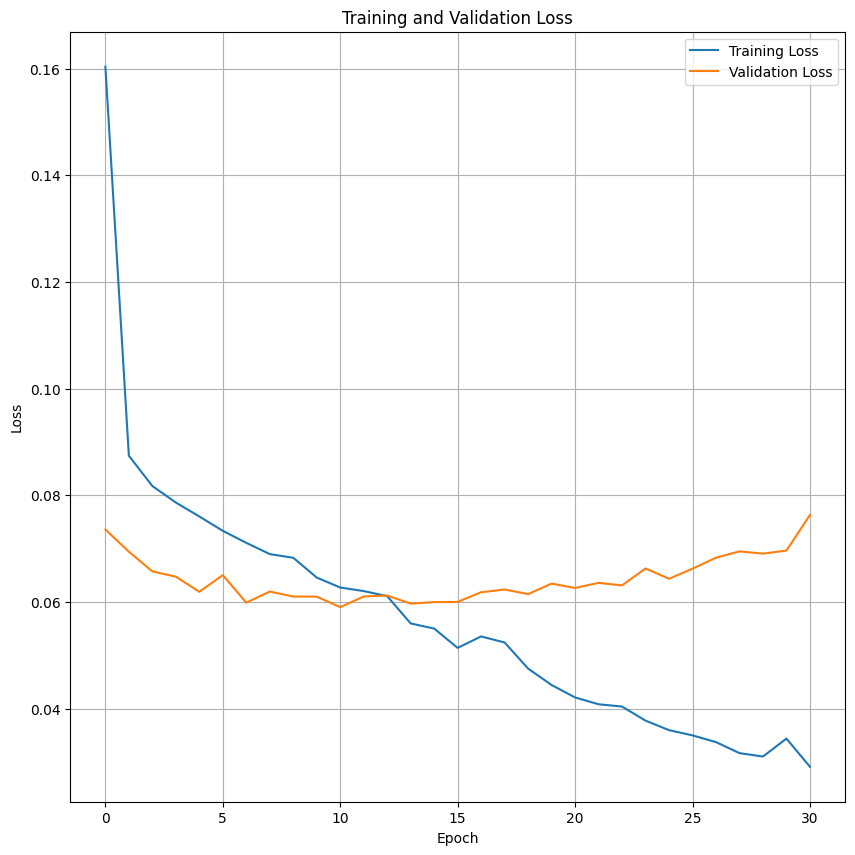

In [20]:
plt.figure(figsize=(10, 10))
plt.plot(resultsDF['epoch'], resultsDF['training_loss'], label="Training Loss")
plt.plot(resultsDF['epoch'], resultsDF['val_loss'], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

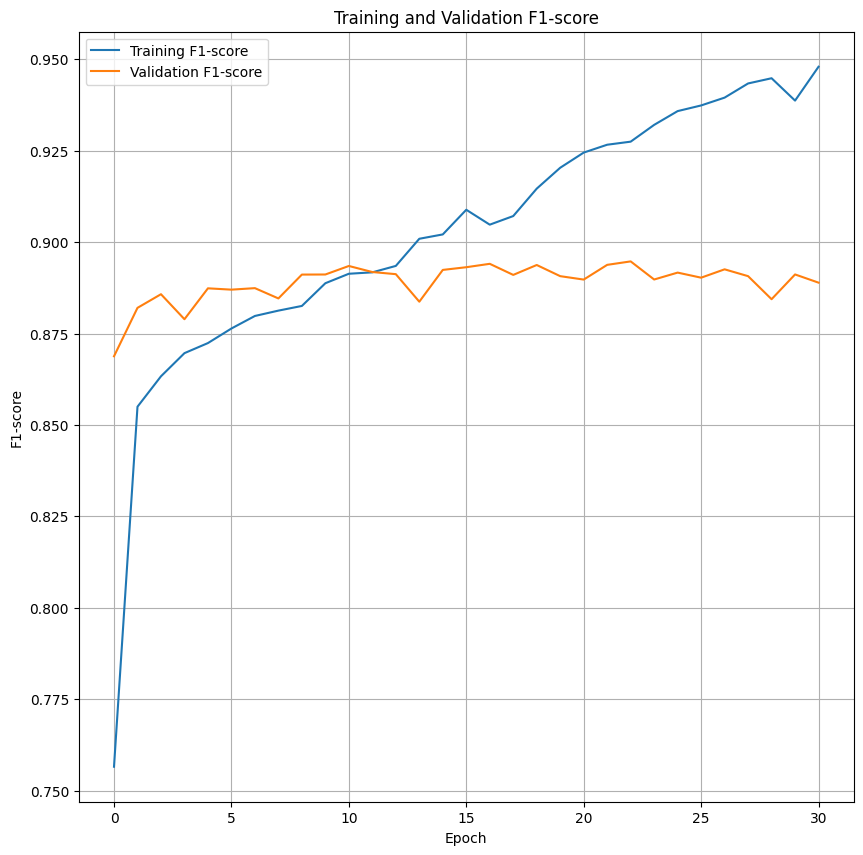

In [17]:
plt.figure(figsize=(10, 10))
plt.plot(resultsDF['epoch'], resultsDF['training_f1'], label="Training F1-score")
plt.plot(resultsDF['epoch'], resultsDF['val_f1'], label="Validation F1-score")

plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.title("Training and Validation F1-score")
plt.legend()
plt.grid()
plt.show()

# запустим на тестовых данных

In [3]:
device = 'cuda'  

In [4]:
encoder_weights = 'imagenet'
activation = None
model = smp.DeepLabV3(
    encoder_weights=encoder_weights, 
    classes=2, 
    activation=activation,
).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 85.1MB/s]


In [5]:
checkpoint_path = "/home/jupyter/datasphere/project/results/crack_dlv3_model.pt"
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))



<All keys matched successfully>

In [14]:
dataset_dir_path = '/home/jupyter/datasphere/project/CRACK500'
test_ds = SegData(dataset_path=dataset_dir_path, file_name='test.txt', transform=None)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 4, shuffle=True, num_workers=0, drop_last=True)


In [13]:
  
acc = tm.Accuracy(task="multiclass", average="micro", num_classes=2).to(device)
f1 = tm.F1Score(task="multiclass", average="macro", num_classes=2).to(device)
iou_metric = tm.JaccardIndex(task="binary").to(device)
prec = tm.Precision(task="binary").to(device)
rec = tm.Recall(task="binary").to(device)

In [14]:
model.eval()


DeepLabV3(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [15]:
with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        acc.update(outputs, targets)
        f1.update(outputs, targets)
        iou_metric.update(torch.argmax(outputs, dim=1), targets)
        prec.update(torch.argmax(outputs, dim=1), targets)
        rec.update(torch.argmax(outputs, dim=1), targets)

acc = acc.compute()
f1 = f1.compute()
m_iou = iou_metric.compute()
prec = prec.compute()
rec = rec.compute()

print(f'Test Accuracy: {acc:.4f}, Test F1: {f1:.4f}, Test IoU: {m_iou:.4f}')
print(f'Test Precision: {prec:.4f}, Test Recall: {rec:.4f}')


Test Accuracy: 0.9679, Test F1: 0.8518, Test IoU: 0.5633
Test Precision: 0.7008, Test Recall: 0.7418


In [1]:
acc = 0.9679
f1 = 0.8518
m_iou = 0.5633
prec = 0.7008
rec = 0.7418

# построение Penta-diagram

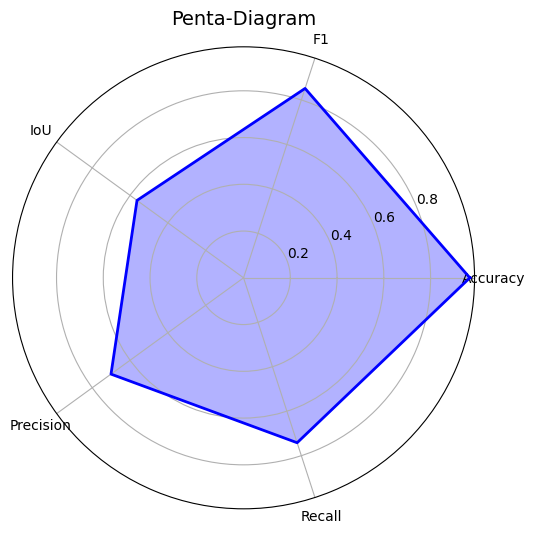

In [7]:
num_vars = 5

values = [acc, f1, m_iou, prec, rec]
values += values[:1]  # Замкнуть график

# Углы для вершин пятиугольника
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Замыкание графика

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.fill(angles, values, color='b', alpha=0.3)
ax.plot(angles, values, color='b', linewidth=2)

labels = ['Accuracy', 'F1', 'IoU', 'Precision', 'Recall']
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
#ax.set_yticks()
#ax.set_yticklabels()
ax.set_title("Penta-Diagram", fontsize=14)

plt.show()

# Строим ROC и PR кривые для val датасета

In [6]:
dataset_dir_path = '/home/jupyter/datasphere/project/CRACK500'

val_ds = SegData(dataset_path=dataset_dir_path, file_name='val.txt', transform=None)

val_dl = torch.utils.data.DataLoader(val_ds, batch_size=4, shuffle=True, num_workers=2)

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
def plot_roc_curve(true_flat, prob_flat):
    fpr, tpr, _ = roc_curve(true_flat, prob_flat)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


In [ ]:
def plot_precision_recall_curve(true_flat, prob_flat):
    precision, recall, _ = precision_recall_curve(true_flat, prob_flat)
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label="Precision-Recall")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

In [9]:
all_probs = []
all_trues = []

In [10]:
model.eval()
with torch.no_grad():
    for images, masks in val_dl:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1, :, :].cpu().numpy()
        all_probs.append(probs.flatten())
        all_trues.append(masks.numpy().flatten())

In [11]:
all_probs = np.concatenate(all_probs)
all_trues = np.concatenate(all_trues)

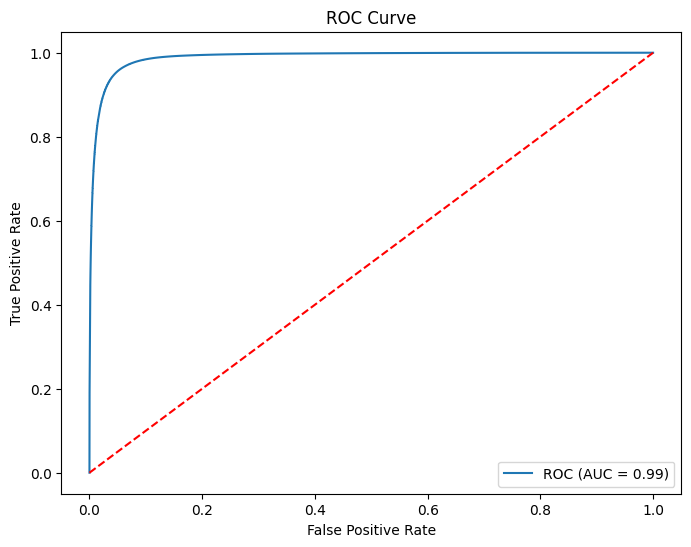

In [11]:
plot_roc_curve(all_trues, all_probs)

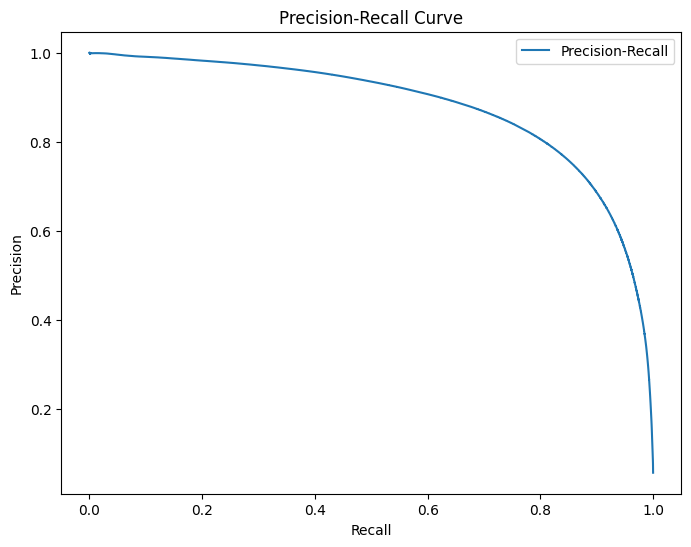

In [12]:
plot_precision_recall_curve(all_trues, all_probs)